<a href="https://colab.research.google.com/github/HDoubleH/SteamDBMachineLearningProject/blob/main/SteamDBProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Steam Games Dataset Analysis

Project Goal: Analyze Steam games data to understand pricing patterns,          game popularity trends, and factors influencing game success

Dataset: Steam Games Dataset from Kaggle (fronkongames/steam-games-dataset)

Author: Owen Hurst-Hopf

Date: November 2025


In [2]:
# Database Setup
import os
import kagglehub
from google.colab import userdata

try:
  os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
  os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
except Exception as e:
  print(f"Error: {e}")

dataset_slug = "fronkongames/steam-games-dataset"
path = kagglehub.dataset_download(dataset_slug, force_download=True)
print(f"Dataset successfully download at : {path}")


Using Colab cache for faster access to the 'steam-games-dataset' dataset.
Dataset successfully download at : /kaggle/input/steam-games-dataset


# Cleaning the data
The Steam games CSV dataset had rows with differing number of columns due to the "About the Game" text column including commas that were being parsed as seperators. To fix this, the file was parsed using Python's csv.reader with the proper quotign so that commas inside quotes weren't being interpreted. Misaligned rows were identified by counting columns, and consectutive columns were then combined to restore the original "About the Game" field. The cleaned rows were then put in a DataFrame **df**, and the numeric coluumns were converted to the appropriate type.

In [3]:
# Data Cleaning
import pandas as pd
import csv, sys
from collections import Counter

file_path = f"{path}/games.csv"

# increase field limit (we already did this earlier, but safe to ensure)
csv.field_size_limit(sys.maxsize)

# Read with csv.reader using proper quoting
with open(file_path, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',', quotechar='"')
    rows = list(reader)

print("Total rows (including header):", len(rows))
header = rows[0]
target_len = len(header)
print("Header columns:", target_len)

# Count field-length frequencies
lens = [len(r) for r in rows]
cnt = Counter(lens)
print("Field counts frequency (len: count):")
for l, c in sorted(cnt.items()):
    print(f"  {l}: {c}")

# Quick lists
# Check for proper length
good_rows = [r for r in rows[1:] if len(r) == target_len]
bad_rows = [r for r in rows[1:] if len(r) != target_len]
print(f"\nGood rows: {len(good_rows)}  |  Bad rows: {len(bad_rows)}")

# Try to repair bad rows by merging spans (brute-force but small and robust)
def try_fix_row(row, target_len, min_merge_start=6, max_merge_start=12, max_span=200):
    """
    Attempt to merge a contiguous span of fields in `row` into one field
    so the resulting length equals target_len.
    We try merge starts between min_merge_start..max_merge_start (defaults chosen
    where 'About the game' often sits). Returns fixed row or None.
    """
    L = len(row)
    # if row already correct, return as is
    if L == target_len:
        return row

    # Try merge start positions in a reasonable range
    for start in range(min_merge_start, max_merge_start + 1):
        # ensure start in bounds
        if start >= L:
            continue
        end = start + (L - target_len) + 1
        # Only try realistic end within bounds
        if end <= start or end > L:
            continue
        # Merge row[start:end] into one field
        merged = ",".join(row[start:end])   # use comma join to preserve commas
        new_row = row[:start] + [merged] + row[end:]
        if len(new_row) == target_len:
            return new_row
    max_end_span = min(L, start + max_span) if 'start' in locals() else min(L, 200)
    for start in range(3, min(20, L)):  # try starts 3..19
        for end in range(start + 1, min(L + 1, start + 80)):
            new_row = row[:start] + [",".join(row[start:end])] + row[end:]
            if len(new_row) == target_len:
                return new_row
    return None

fixed = []
unfixable = []
for i, r in enumerate(rows[1:], start=1):
    if len(r) == target_len:
        fixed.append(r)
    else:
        fr = try_fix_row(r, target_len)
        if fr is not None:
            fixed.append(fr)
        else:
            # keep original but mark as unfixable for inspection
            unfixable.append((i, r))

print(f"Repaired rows: {len(fixed) - len(good_rows)}")
print(f"Unfixable rows (count): {len(unfixable)}")


# build DataFrame (df) from header + fixed rows
if len(fixed) > 0:
    df = pd.DataFrame(fixed, columns=header)
    print("\nDataFrame created from repaired rows.")
    print("Shape:", df.shape)
    display(df.head(3))

    # list all numeric columns
    numeric_cols = [
        'AppID', 'Peak CCU', 'Required age', 'Price', 'DiscountDLC count',
        'Metacritic score', 'User score', 'Positive', 'Negative', 'Score rank',
        'Achievements', 'Recommendations',
        'Average playtime forever', 'Average playtime two weeks',
        'Median playtime forever', 'Median playtime two weeks'
    ]

    # Finally convert numeric columns to correct type
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].str.replace(',', '').str.strip(), errors='coerce')

else:
    print("No rows could be fixed into a DataFrame. Please inspect sample unfixable rows above.")


Total rows (including header): 111453
Header columns: 39
Field counts frequency (len: count):
  39: 1
  40: 111452

Good rows: 0  |  Bad rows: 111452
Repaired rows: 111452
Unfixable rows (count): 0

DataFrame created from repaired rows.
Shape: (111452, 39)


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,"19.99,0",0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,"0.99,0",0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,"4.99,0",0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


# Drop Columns
Some columns don't provide any meaningful data to examine for EDA or for Machine Learning, we will drop those here.

In [4]:
# Drop columns that provide useless information for learning
cols_to_drop = [
    'Header image', 'Website', 'Support url', 'Support email',
    'Screenshots', 'Movies', 'Notes', 'Metacritic url'
]

df.drop(columns=cols_to_drop, inplace=True)
df.columns

Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DiscountDLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'User score', 'Positive',
       'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags'],
      dtype='object')

# Exploratory Data Analysis


In [10]:
# Overview of dataset and important imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isna().sum())
print("\nBasic Descriptive Statistics:")
display(df.describe())

,Genres
0,"Casual,Indie,Sports"
1,"Action,Indie"
2,"Action,Adventure,Indie,Strategy"
3,"Adventure,Casual,Indie"
4,"Adventure,Indie"
5,"Adventure,Casual,Free to Play,Massively Multip..."
6,"Indie,Strategy"
7,Casual
8,"Adventure,RPG,Simulation,Strategy"
9,"Action,Adventure,Indie"


From the overview we can see that some columns need some feature engineering, specifically estimated owners, which provides a range (i.e '0-10000) as its value. Beyond this Score Rank is missing a majority of its values, and would should be added to the drop list, where the rest of the values are properly filled out. The dataset also contains exetreme outlier in many columns, with a majority of the Interquartile range being zero. This means that a majority of the games have minimal engagement, with outliers dominated most metrics.
Overall, the data is heavily imbalanced towards non-successful games, so there may be a need for transformations to apply to machine learning models.

In [18]:
# We drop ScoreRank because most of its values are missing, and without stict feature engineering it wouldn't give any insights for model predictions
df.drop(columns=['Score rank'], inplace=True)
print(df.shape)

TypeError: 'tuple' object is not callable

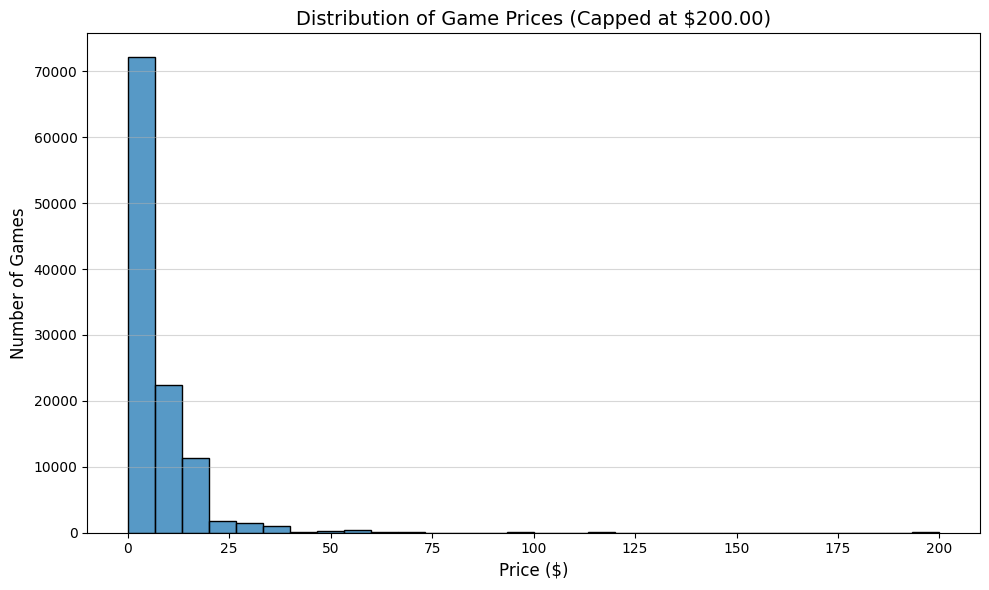

Total number of games: 111452
Number of free games (Price = $0.00): 23247
Percentage of free games: 20.86%


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

price_cap = 200
price_data = df[df['Price'] <= price_cap]['Price']

# 2. Calculate the count and percentage of free games
free_games_count = (df['Price'] == 0.00).sum()
total_games = df.shape[0]

# 3. Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(price_data, bins=30, kde=False)
plt.title(f'Distribution of Game Prices (Capped at ${price_cap}.00)', fontsize=14)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

# Print summary statistics for free games
print(f"Total number of games: {total_games}")
print(f"Number of free games (Price = $0.00): {free_games_count}")
print(f"Percentage of free games: {free_games_count / total_games * 100:.2f}%")


The price distribution is heavily skewed to the right, with the majority of them being priced less than 10$ or free. This most likely means that most of the data for predicting 'success' will have to come from games that are paid for, where a simple linear regression would fit nicely, but the free games could work very well for classification. The distinction between free and paid games could prove useful for classification models,

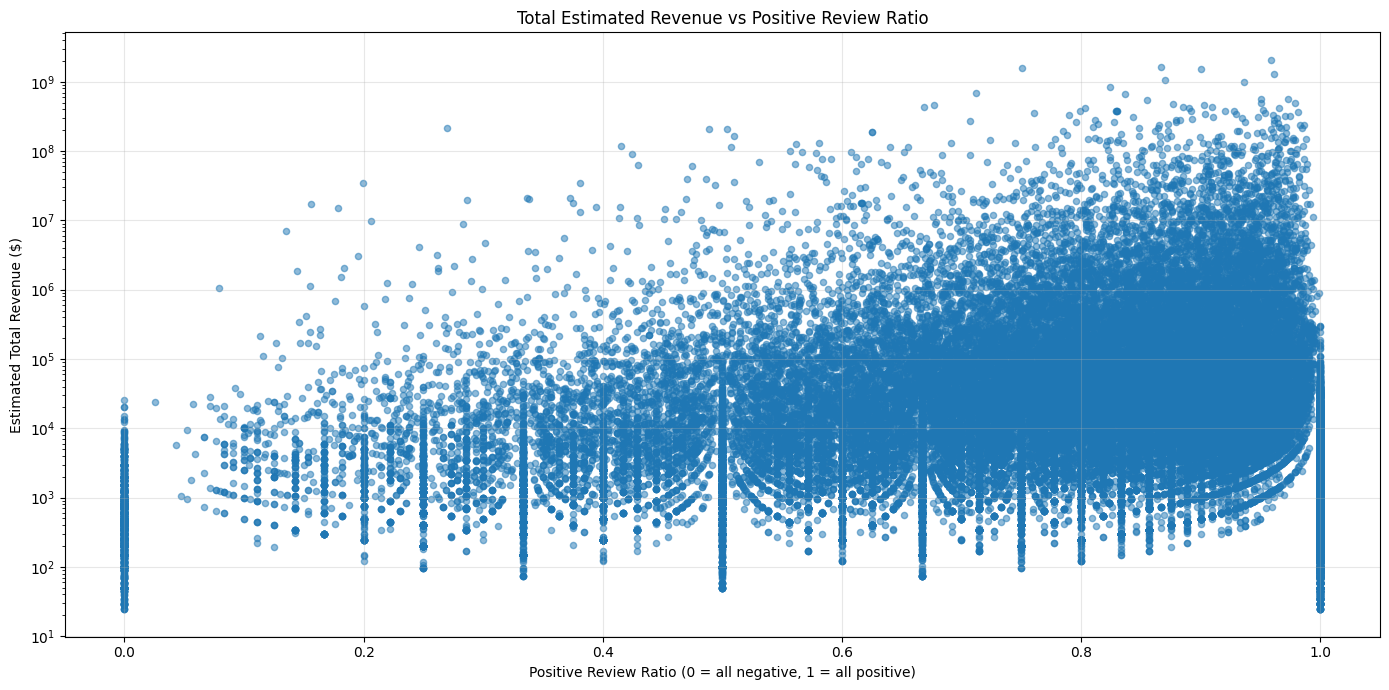

Total estimated revenue across all paid games: $83,662,157,611.96
Average revenue per game: $1,263,969.75
Median revenue per game: $4,492.50


In [ ]:
import matplotlib.pyplot as plt

# Filter paid games
paid_games = df[df['Price'] > 0].copy()

# Calculate total reviews and positive ratio
paid_games['total_reviews'] = paid_games['Positive'] + paid_games['Negative']
paid_games['positive_ratio'] = paid_games['Positive'] / paid_games['total_reviews']

# Calculate estimated UNITS sold (50 units per review)
paid_games['estimated_units'] = paid_games['total_reviews'] * 50

# Calculate estimated REVENUE (units * price)
paid_games['estimated_revenue'] = paid_games['estimated_units'] * paid_games['Price']

# Remove games with no reviews
paid_games = paid_games[paid_games['total_reviews'] > 0]

plt.figure(figsize=(14, 7))
plt.scatter(paid_games['positive_ratio'], paid_games['estimated_revenue'], alpha=0.5, s=20)
plt.xlabel('Positive Review Ratio (0 = all negative, 1 = all positive)')
plt.ylabel('Estimated Total Revenue ($)')
plt.yscale('log')
plt.title(f'Total Estimated Revenue vs Positive Review Ratio')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show some statistics
print(f"Total estimated revenue across all paid games: ${paid_games['estimated_revenue'].sum():,.2f}")
print(f"Average revenue per game: ${paid_games['estimated_revenue'].mean():,.2f}")
print(f"Median revenue per game: ${paid_games['estimated_revenue'].median():,.2f}")



The scatter plot of the estimated revenue against a positive review ratio shows that well reviewed games are more likely to be successful, it does not guarentee success. Many well reviewed games still pool at the bottom of the estimated revenue scale, so fitting a regression model will prove to be difficult. This may mean using a classification model to group based on some revenue metric, such as over 20,000 in estimated sales is success, would be more appropriate.

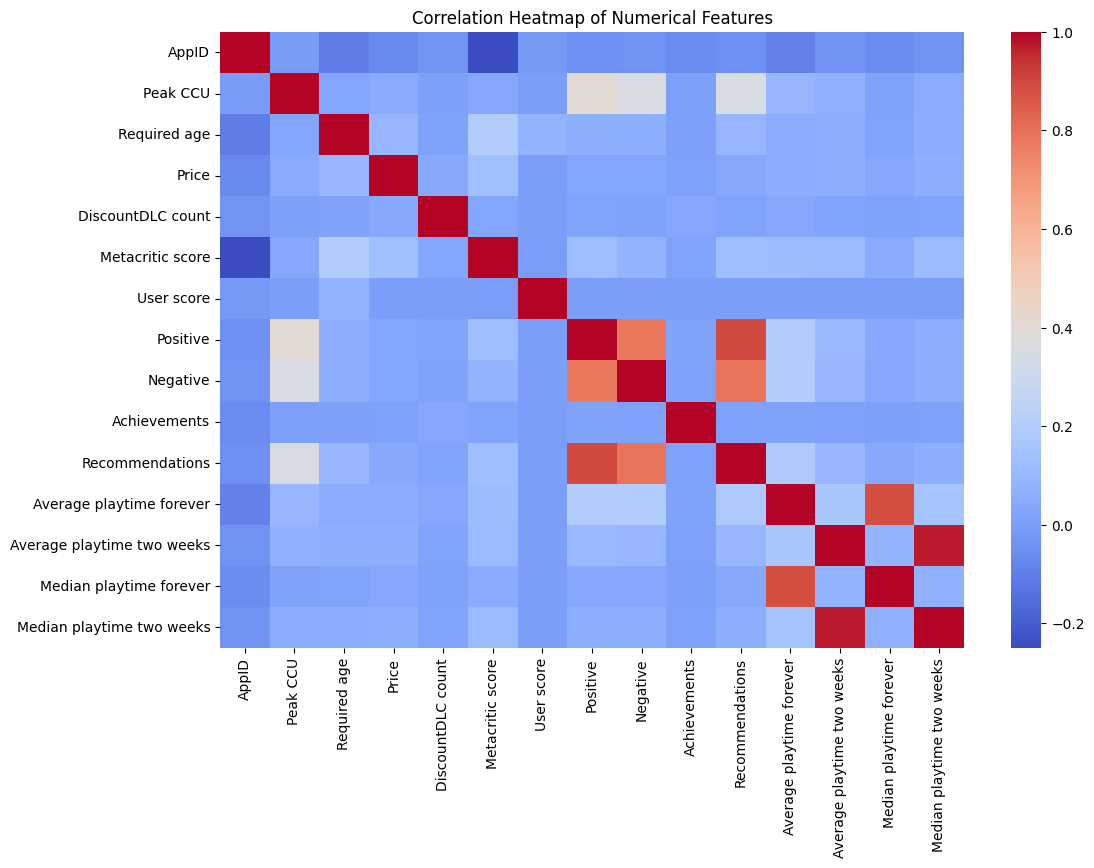

In [19]:
# Heatmap for numeric feature correlation
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12,8))
sns.heatmap(numeric_cols.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

The heatmap of Numerical feature correlation shows that price does dictate success, as many games succeed both free, cheap, and expensive. Overall I believe this shows that regression won't be impactful due to low correlation, and classification may prove fruitful to possibly predict 'well reviewed' games.  

# EDA Summary
The histogram shows that the distribution of game prices is heavily right-skewed, indicating that most games fall under $10.

Only a small portion are greater than
$20, and very few are priced above $$50. This shows that there is an exetreme imbalance where the steam games marketplace is dominated by low-cost and free-to-play titles. In contrast, there are much fewer expensive AAA titles, representing a small fraction of releases. For predictive modeling, this skew tells us that predicting success in games will have to be trained on a smaller subset of paid games, exluding free-to-play. On the matter of free games, they offer little value for regression but may prove meaninful for predicting classicifations tasks when compared with paid games for engagement.

The correlation heatmap shows that most numerical features are only weakly correlated with each other and other revenue related metrics, which probably indictates that linear regression is unlikely to perform well to capture meaningful trends in the data. Review counts and playtime metrics show high intercorrelation, showing that maybe they are redundant, and may need PCA. Price shows no correlation with the other features, which makes sense as game success is not related to price, many succeceed on both ends of the spectrum. Given this nonlinear behaivor with price, a classifcation-based approach, like predicting 'successful' or 'not successful' based on thresholds for reviews, sales, or playercounts, is the way to go. Overall, this shows that the dataset is most likely fit for tree-based classifiers and/or ensemble models.

In [8]:

from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
df.to_pickle('/content/drive/MyDrive/steam_games_cleaned.pkl')

print("✓ DataFrame saved successfully to Google Drive!")
print(f"Cleaned DataFrame saved successfully to /steam_games_cleaned.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ DataFrame saved successfully to Google Drive!
Cleaned DataFrame saved successfully to /steam_games_cleaned.csv
